In [1]:
import pickle
import marshal
import numpy as np
import matplotlib.pyplot as plt
from save_measures import Run
from config import ExperimentType
from correlations import initialization_correlation, conditional_correlation, hp_correlation
from plotting import correlation_envelope

In [66]:
def conditional_correlation(pair_corrs, condition):
    def extract_corrs(name):
        corr_dict = pair_corrs[name]
        corrs = {}

        for hp_pair, steps_dict in corr_dict.items():
            if not condition(hp_pair):
                continue

            for step, measures in steps_dict.items():
                if name == "weighted":
                    measures_dict, num_pairs, total_weight = measures
                else:
                    measures_dict, num_pairs = measures
                    total_weight = num_pairs

                step_corrs = corrs.get(step, {})

                for measure, corr in measures_dict.items():
                    step_measure_corrs = step_corrs.get(measure, [])
                    step_measure_corrs.append((corr, num_pairs, total_weight))
                    step_corrs[measure] = step_measure_corrs

                corrs[step] = step_corrs

        return corrs
    
    weighted_corrs = extract_corrs("weighted")
    unweighted_corrs = extract_corrs("unweighted")

    return {"weighted": weighted_corrs, "unweighted": unweighted_corrs}

In [73]:
def new_correlation(pair_corrs):
    def condition(hp_pair):
        return hp_pair[0][1] != 3 and hp_pair[1][1] != 3

    return conditional_correlation(pair_corrs, condition)

In [74]:
steps = [0.001, 0.01, 0.1, 1] + list(range(5, 301, 5))
corrs = {}
corrs["test_acc"] = []

for a in ["margin", "exponential_margin", "normalized_exponential_margin", "shifted_margin", 
          "pac_bayes", "vc_dim", "norms", "optimisation"]:
    with open("./data.nosync/pre-comp-correlations-future/{}-best.pickle".format(a), "rb") as f:
        pair_corrs = pickle.load(f)
    
    corrs[a] = []
    overall_corrs = new_correlation(pair_corrs)
    
    for s in steps:
        max_corr = 0
        for x in overall_corrs["weighted"][s]:
            c = abs(np.mean([b[0] for b in overall_corrs["weighted"][s][x] if b[2] > 1]))
            
            if x == "accuracy/test":
                corrs["test_acc"].append(c)
            elif c > max_corr:
                max_corr = c
        
        corrs[a].append(max_corr)

In [75]:
margin = []
for i in range(len(steps)):
    margin.append(max(corrs["margin"][i], corrs["exponential_margin"][i], 
                      corrs["normalized_exponential_margin"][i], corrs["shifted_margin"][i]))
    
corrs_new = {k: v for k, v in corrs.items() if k in ["pac_bayes", "vc_dim", "norms", "optimisation", "test_acc"]}
corrs_new["margin"] = margin

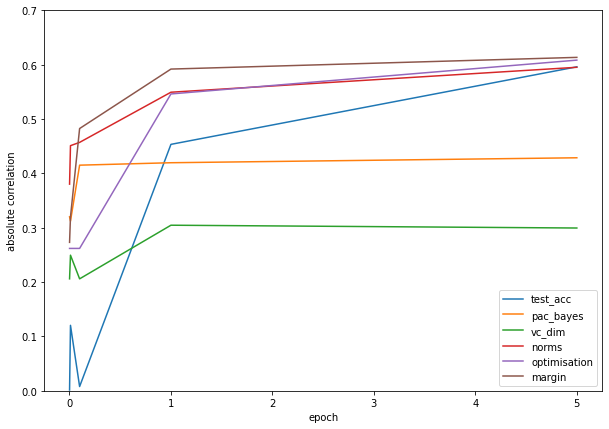

In [79]:
plt.figure(figsize=(10, 7))
for x in corrs_new:
    plt.plot(steps[:5], corrs_new[x][:5], label=x)

plt.ylim([0, 0.7])
plt.xlabel("epoch")
plt.ylabel("absolute correlation")
plt.legend()
plt.show()

In [21]:
def new_correlation(pair_corrs):
    def condition(hp_pair):
        return hp_pair[0][1] == "no_dropout" and hp_pair[1][1] == "no_dropout"

    return conditional_correlation(pair_corrs, condition)

In [22]:
steps = [1] + list(range(5, 301, 5))
corrs = {}
corrs["test_acc"] = []

for a in ["margin", "exponential_margin", "normalized_exponential_margin", "shifted_margin", 
          "pac_bayes", "vc_dim", "norms", "optimisation"]:
    with open("./data.nosync/pre-comp-correlations-future/{}-best.pickle".format(a), "rb") as f:
        pair_corrs = pickle.load(f)
    
    corrs[a] = []
    overall_corrs = new_correlation(pair_corrs)
    
    for s in steps:
        max_corr = 0
        for x in overall_corrs["weighted"][1]:
            c = abs(np.mean([b[0] for b in overall_corrs["weighted"][s][x] if b[2] > 1]))
            
            if x == "accuracy/test":
                corrs["test_acc"].append(c)
            elif c > max_corr:
                max_corr = c
        
        corrs[a].append(max_corr)

KeyError: 1

In [ ]:
for x in corrs:
    plt.plot(steps[:20], corrs[x][:20], label=x)

plt.ylim([0, 1])
plt.legend()
plt.show()

In [58]:
print(len(pair_corrs["weighted"]))

overall_corrs = new_correlation(pair_corrs)

16290


In [65]:
steps = range(0, 301, 5)
for s in steps:
    corrs = [a[0] for a in overall_corrs["weighted"][s]["pacbayes_mag_init"]]
    corr = np.mean(corrs)
    print("{}: {}".format(s, corr))

0: 0.0
5: 0.10762155370792875
10: 0.06479056995580013
15: 0.06526755164431398
20: 0.08498238224202197
25: 0.11206476121612481
30: 0.13227251747698676
35: 0.12298779657788834
40: 0.15701360496671077
45: 0.17497603396582756
50: 0.16691875888543098
55: 0.21580604945532322
60: 0.35714971861834
65: 0.3747642034415883
70: 0.35915446308962345
75: 0.36421686707788514
80: 0.4038938028936933
85: 0.39420584159127164
90: 0.3908032387523601
95: 0.3705214827791917
100: 0.37621658758974186
105: 0.36372329446320273
110: 0.35412798628221237
115: 0.37548722269787616
120: 0.3618865350829558
125: 0.3799873603475402
130: 0.37459478403565033
135: 0.36411584725007873
140: 0.3520943842043113
145: 0.34712583453010015
150: 0.3558554138036613
155: 0.32499404552898803
160: 0.3021311065335501
165: 0.30276580270985987
170: 0.28715765392450515
175: 0.27743214990399645
180: 0.28381976689827826
185: 0.2923168072918857
190: 0.27621511111260116
195: 0.284636718492336
200: 0.279698613869247
205: 0.2761286483951796
210: 0

In [35]:
# for a in ["margin", "exponential_margin", "normalized_exponential_margin", "shifted_margin", 
#           "pac_bayes", "vc_dim", "norms", "optimisation"]:
steps = range(0, 301, 5)
for s in steps: 
    corrs = [a[0] for a in overall_corrs["weighted"][s]["pacbayes_init"]]
    corr = np.mean(corrs)
    print("{}: {}".format(s, corr))

# for x in overall_corrs["weighted"][10]:
#     corr = np.mean([a[0] for a in overall_corrs["weighted"][10][x]])
#     print("{}: {}".format(x, corr))

0: 0.0
5: -0.29241930631131197
10: -0.2974005672072708
15: -0.34748281938052217
20: -0.34124944823872816
25: -0.33345827039448755
30: -0.3384677748655171
35: -0.3463545532359789
40: -0.34634150654055285
45: -0.3453390225211282
50: -0.34617980747495486
55: -0.3456984731387464
60: -0.34905272728361453
65: -0.3500566156652211
70: -0.35120475525677575
75: -0.3493952050886983
80: -0.348301803671109
85: -0.3469611992854857
90: -0.3471913621775453
95: -0.34780516040358295
100: -0.3471384863395675
105: -0.34661191475626313
110: -0.34603299115217895
115: -0.3468747054582007
120: -0.34778983646568534
125: -0.3497879971047714
130: -0.34961560407311454
135: -0.34973499125677665
140: -0.34806876882338833
145: -0.3482611378828208
150: -0.34761596338744116
155: -0.34775717166977
160: -0.34768146386968857
165: -0.3472889037002476
170: -0.3515084158667059
175: -0.34947874861768
180: -0.3496690796511317
185: -0.34797884435589826
190: -0.34984823791515895
195: -0.34856459191013744
200: -0.348716084529507

In [3]:
with open("./data.nosync/pre-comp-pairs-future/pac_bayes-best.pickle", "rb") as f:
    pairs = pickle.load(f)